---
__Universidad Tecnológica Nacional, Buenos Aires__\
__Ingeniería Industrial__\
__Cátedra de Logística__\
__Autor: Rodrigo Maranzana__,  Rmaranzana@frba.utn.edu.ar

---

# Ruteo de Vehículos mediante el Sweep Algorithm

## Introducción

El ruteo de vehículos es uno de los problemas más complejos en el campo de grafos, optimzación de redes y gestión logística. En este caso lo abordamos desde un algoritmo conocido como Sweep. Éste, es capaz de llegar a soluciones subóptimas para el problema del Ruteo de Vehículos con restricciones de Capacidad. En esta clase de problemas, los vehículos tienen una capacidad máxima de carga, y además cada uno de los destinos demanda una cantidad fija de producto.

## Notas iniciales de configuración

Para los que usan Anaconda, es necesario instalar:
- Mediante .whl: GDAL, Fiona
- En la consola de anaconda: conda install shapely

## Herramientas

En primer lugar, vamos a importar las librerías necesarias:

Numpy es una librería de manipulación algebraica y computación científica.

Matplotlib es una librería de ploteo y visualización.

OSMNX es un paquete que toma información del mapa open-source OpenStreetMap y convierte destintos puntos de interés en un grafo del paquete NetworkX. Esta última, es una poderosa librería que permite estudiar grafos e implementar sobre ellos una variedad enorme de algoritmos y métricas.

Info adicional:
- https://matplotlib.org/
- https://numpy.org/
- https://osmnx.readthedocs.io/en/stable/
- https://networkx.org/

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx

## Construcción y prueba inicial del algoritmo Sweep

### Datos Iniciales
Sobre un plano, tenemos un depósito central ubicado en una posición x, y = (0.5, 0.5). Por otro lado, contamos con 20 clientes dispersos alrededor de este depósito. La posición x, y de los clientes se genera aleatoriamente.

Cada cliente demanda una cantidad que está alrededor de una media de 500, pero es un valor aleatoriamente generado.

Por último, se cuenta con 3 camiones, cada uno con una capacidad de carga fija.

In [22]:
# Cantidad de clientes:
n = 20

# Coordenadas de los clientes:
x = np.random.rand(n)
y = np.random.rand(n)
coord = list(zip(x, y))

# Demanda de cada cliente:
q_clientes = np.random.rand(n) * 500

# Posición del depósito:
p0 = (0.5, 0.5)

# Lista con la capacidad de cada camión:
q_camiones = [2000, 2000, 2300]

Para tener un mejor entendimiento de la situación, vamos a plotear el depósito central y los clientes dispersos en un gráfico x,y:

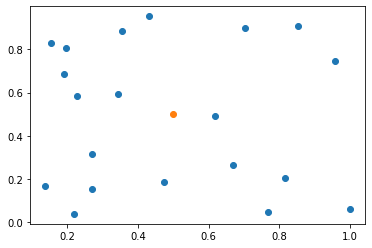

In [23]:
plt.scatter(x, y)
plt.scatter(*p0)
plt.show()

## Cálculo del ángulo entre el depósito y cada cliente:

La clave del algoritmo Sweep implica recorrer escaneando desde el depósito cada punto de cliente emulando el movimiento de un reloj. Por lo tanto el cálculo del ángulo entre el vector vertical y el vector que se genera entre el depósito y cada cliente, es muy importante.

Para calcular este vector, hacemos lo siguiente:
- Calculamos dx, como la diferencia entre la posición x del cliente y la posición x del depósito.
- Calculamos dy, como la diferencia entre la posición y del cliente y la posición x del depósito.
- Calculamos el ángulo, usando la siguiente fórmula: $ \alpha = \arctan{(dx, dy)} $



In [24]:
def calcular_angulo(p1, p2):
    dx = p2[0]-p1[0]
    dy = p2[1]-p1[1]

    return math.atan2(dx, dy)

Lo próximo, implica poder repetir el cálculo anterior para todos los clientes. Es decir, obtener en una lista los ángulos entre el depósito y cada cliente.

Dado que los valores de las coordenadas puede ser cualuier número, vamos a normalizarlos para tenerlos entre 0 y 1; de esta manera facilitar los cálculos.

La normalización implica:

$ X_i^{norm} = \frac{X_i - max(X)}{max(X) - min(X)} $

Luego repetimos el cálculo del ángulo para todos los puntos de clientes ya normalizados.

In [ ]:
def calcular_angulos(p0, x, y):
    # Normalizar
    puntosx = np.append(x, p0[0])
    puntosy = np.append(y, p0[1])
    
    puntosxnorm = (puntosx - min(puntosx)) / (max(puntosx) - min(puntosx))
    puntosynorm = (puntosy - min(puntosy)) / (max(puntosy) - min(puntosy))
    
    clientesxnorm = puntosxnorm[:-1]
    clientesynorm = puntosynorm[:-1]
    p0norm = (puntosxnorm[-1], puntosynorm[-1])
    
    # Retornar angulos
    return [calcular_angulo(p0norm, (xi, yi)) for xi, yi in zip(clientesxnorm, clientesynorm)]

A continuación, vamos a ubicar toda la información que tenemos en un Numpy array. Podemos entender esto como una especie de tabla que contiene los campos:

- Coordenada X del cliente
- Coordenada Y del cliente
- Cantidad demandada por el cliente
- Ángulo entre el cliente y el depósito (previamente calculado)

Por último, ordenamos a los clientes según su ángulo. De esta manera, al recorrer la lista, estamos escaneando a los clientes en un sentido horario o antihorario, dependiendo de cómo se ordenó.

In [25]:
def armar_np_array_clientes(x, y, q_clientes, angulo):
    # Declarar dtypes:
    dtypes = [('x', float), ('y', float), ('q', float), ('angulo', float)]
    
    # Armar nparray:
    array_clientes = np.array(list(zip(x, y, q_clientes, angulo)), dtypes)

    # Ordenar:
    return np.sort(array_clientes, order='angulo')

Ahora sí, condensamos todo lo que armamos en una función para el algoritmo Sweep:

Como inputs tenemos: coordenadas de clientes y sus cantidades demandadas; capacidad de camiones, coordenadas del depósito.

El procedimiento es el siguiente:

```
| Individualizamos en listas las coordenadas X e Y.
| Calculamos los ángulos entre depósito y clientes.
| Creamos el Numpy array de clientes ya ordenado según el ángulo.
| Inicializamos variables que vamos a llenar más adelante: una lista "current_q" que va a tener la carga del camión, va a ir creciendo a medida que le asignemos clientes; una lista "asignados" que contiene los clientes que corresponden a cada camión. Por último inicializamos un contador de clientes "j".
|
| Iteramos para cada camión i:
| | Asignamos el depósito al camión i (parte del depósito)
| |
| | Mientras el camión i tenga capacidad:
| | | Aumentamos current_q del camión i con la demanda del cliente j.
| | | Asignamos al cliente j al camión i.
| | | Aumentamos j, es decir, pasamos al próximo cliente.
| |
| | Asignamos el depósito al camión i (llega al depósito)
|
| devolvemos current_q y asignados
```


In [26]:
def sweep_algorithm(coord, q_clientes, q_camiones, deposito):
    """
    INPUTS:
    coord: coordenadas de clientes.
    q_clientes: lista con la demanda de cada cliente.
    q_camiones: lista con la capacidad de cada camión.
    deposito: tupla con posición x e y del depósito.
    OUTPUTS:
    asignados: lista que contiene los clientes asignados a cada camión.
    current_q: lista que contiene la carga efectiva de cada camión.
    """
    
    # Separamos las coordenadas de clientes en x e y:
    coordxy = list(zip(*coord))
    x = coordxy[0]
    y = coordxy[1]
    
    # Calculamos en ángulo de cada cliente respecto del depósito:
    angulo = calcular_angulos(deposito, x, y)
    
    # Convertimos el input en un Numpy array con 4 posiciones: coordendas x, y, cantidad y ángulo.
    array_clientes = armar_np_array_clientes(x, y, q_clientes, angulo)
    
    # Inicializar variables:
    current_q = np.zeros(len(q_camiones))
    asignados = [[] for i in range(0, len(q_camiones))]
    j = 0
    
    # Iterar para cada camión:
    for i in range(0,len(q_camiones)):

        # Agregamos deposito en inicio:
        asignados[i].append(deposito)

        # Mientras el camión tenga capacidad, asignar cliente:
        while (j < n) and (current_q[i] + array_clientes[j]['q'] < q_camiones[i]):
            # Aumentar conteo de carga del camión:
            current_q[i] += array_clientes[j]['q']
            # Asignar cliente j al cami'on i:
            coord = (array_clientes[j]['x'], array_clientes[j]['y'])
            asignados[i].append(coord)
            # Ir al próximo cliente j:
            j += 1

        # Agregamos depósito en final:
        asignados[i].append(deposito)

    return asignados, current_q

Usamos la función del Sweep Algorithm para calcular el ejemplo inicial y obtenemos la lista de asignados y la capacidad final de cada camión.

In [27]:
asignados, current_q = sweep_algorithm(coord, q_clientes, q_cam, p0)

Visualizamos nuevamente el mapa de clientes y depósito, pero ahora con el camino de cada uno de los camiones según lo que indica la lista "asignados".

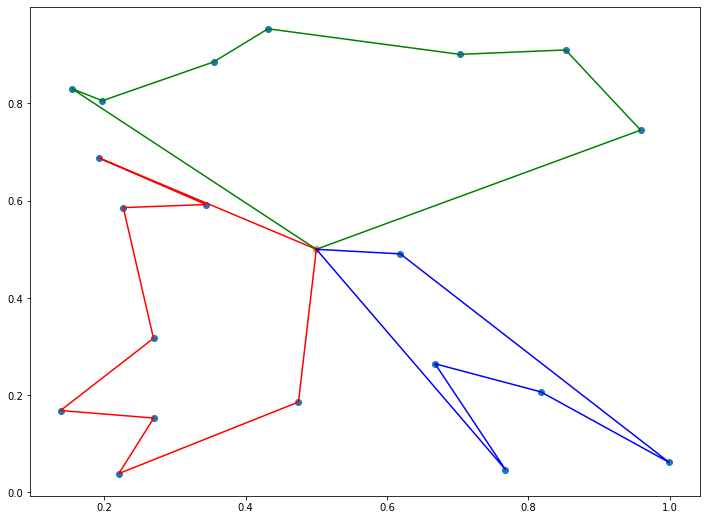

In [28]:
plt.figure(3,figsize=(12,9)) 
plt.scatter(x, y)
plt.scatter(*p0)
for i, c in zip(range(3), ['r', 'g', 'b']):
    plt.plot(*list(zip(*asignados[i])), color=c)
plt.show()

Por último visualizamos la carga de cada camión como un % de su capacidad total.

Como podemos ver, el camión no está lleno al 100%, y el resultado depende del cliente inicial asignado y el sentido de escaneo.

In [35]:
por = [cargai / qi for cargai, qi in zip(current_q, q_camiones)]

print(f"Porcentaje de ocupación de cada camión: {[i*100 for i in por]}")

Porcentaje de ocupación de cada camión: [90.92226005122224, 86.37193741982429, 60.815745846175254]


## Uso del algoritmo Sweep con información geográfica real

### Información inicial y pedido de Spatial Data con OSMNX
En este punto vamos a pedir información a OpenStreetMap mediante la librería OSMNX. La idea es que nos devuelva de una región lo que se conoce como "Spacial Data", que son datos de ubicación geográfica que podemos usar para armar un grafo dirigido.

Vamos a empezar seleccionando distintos puntos de clientes en un mapa, representados por su latitud y longitud en una lista de Python. Podemos buscar estos datos, por ejemplo, en Google Maps.

Además, tenemos los mismos requerimientos que antes: cantidad demandada de cada cliente, camiones con capacidades.


In [41]:
deposito = [-34.59852482887617, -58.41983151401766] # La UTN en Medrano 951

coordsz = [[-34.591705605336095, -58.42052751599947],
           [-34.59467316374631, -58.42709356316284],
           [-34.60195029871818, -58.426278171703636],
           [-34.60650701490135, -58.41160112543803],
           [-34.599512882774185, -58.42992597560005],
           [-34.59933625565085, -58.41589265943383],
           [-34.607566680503055, -58.41996961672983],
           [-34.60168536559613, -58.4125881778376],
           [-34.60613612867437, -58.41964775126066],
           [-34.598046866199944, -58.41211610909806],
           [-34.60406973263275, -58.42741542883317],
           [-34.59802920320026, -58.41243797518788],
           [-34.595309055265645, -58.41969066764075],
           [-34.58806666878552, -58.42112833090869]]

# Cantidad de clientes:
n = len(coordsz)

# Separar las coordenadas x, y:
locations = list(zip(*coordsz))

# Demanda de cada cliente:
q = np.random.rand(n) * 500

# Capacidad de los camiones:
q_camiones = [1000, 1450, 1320]

Usamos el método de ploteo de OSMNX para visualizar a los clientes en rojo, el depósito en rosa y el resto de los puntos geográficos que representan las esquinas de cada calle y puntos importantes.

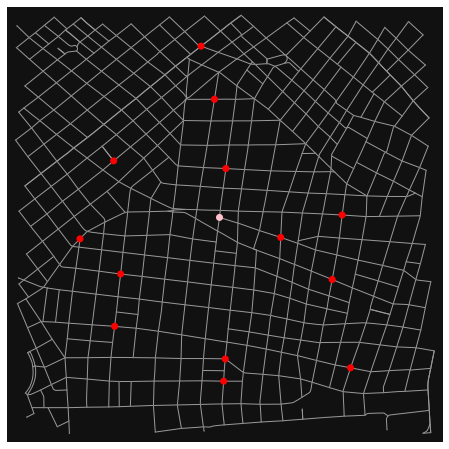

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [37]:
# Armar el grafo desde el depósito:
G = ox.graph_from_point(deposito, network_type='drive', dist=1300)

# Calcular nodos más cercanos a origen y destino:
target = [ox.get_nearest_node(G, coordi) for coordi in coordsz]
deposito_near = ox.get_nearest_node(G, deposito)

nconf = []
for node in G.nodes():
    if node in target:
        nconf.append(('r', 50))
    elif node == deposito_near:
        nconf.append(('pink', 50))
    else:
        nconf.append(('gray', 2))
        
nconf = list(zip(*nconf))
        
# Plot y display:
ox.plot_graph(G, node_color=nconf[0], node_size=nconf[1])

A continuación, simplemente llamamos a nuestro algoritmo de Sweep, con las coordenadas de latitud y longitud del mapa. Hasta este punto, no utilizamos ninguna herramienta de OSMNX, ni otra librería geoespacial para el cálculo.

In [38]:
# Usamos el sweep algorithm para asignar cada cliente a cada vehículo:
asignados, current_q = sweep_algorithm(coordsz, q_clientes, q_camiones, deposito)

Para poder graficar, buscamos los puntos más cercanos entre los clientes reales y los que tenemos del mapa OSMNX. Recordemos, que el mapa descargado no tieen la totalidad de los puntos, sino los más importantes e intersecciones de calles.

In [ ]:
# Asignados a nearest:
asignados_nearest = [[ox.get_nearest_node(G, coordi) for coordi in asign_i] for asign_i in asignados]

Por último, queremos plotear el camino de cada camión. Pero hay una particularidad: antes teníamos caminos rectos, es decir, una distancia euclídea entre cliente y cliente o depósito y cliente. Ahora, las calles tienen direcciones variadas, con un sentido de circulación impuesto.

El recorrido entre un punto y otro está definido por otro problema de optimización diferente: el camino más corto. No vamos a entrar en detalle en este problema, ya que forma parte de otra familia de problemas de optimización. 

Para poder resolverlo, entonces, vamos a usar la funcionalidad "shortest_path" de la librería NetworkX. Con este método podemos calcular el camino más corto entre dos puntos, considerando un grafo geoespacial con calles y sentidos de circulación.

Vamos a calcular un "camino más corto" para cada ruta entre puntos que tiene que efectuar un camión.

Al finalizar, ploteamos lo obtenido.

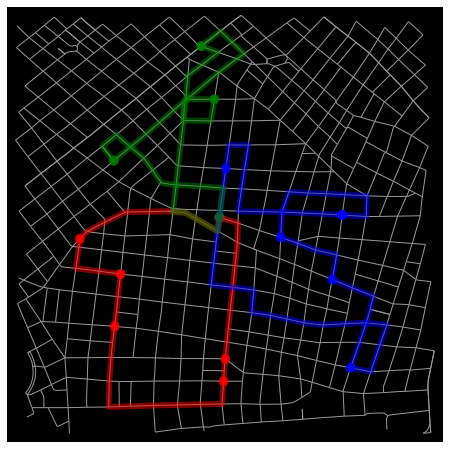

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [39]:
# Calcular shortest path con Networkx
routes = [[nx.shortest_path(G, k[i], k[i+1]) for i in range(0, len(k)-1)] for k in asignados_nearest]

# Colores:
rc = ['r']*len(routes[0]) + ['b']*len(routes[1]) + ['g']*len(routes[2])

# Flatten routes:
froutes = [j for i in routes for j in i]

# Plot y display:
ox.plot_graph_routes(G, froutes, route_linewidth=6, route_colors=rc, node_size=0, bgcolor='k')

Nuevamente, obtenemos la carga de cada camión. Dado que existe un sentido de escaneo, el último camión va a ser el menos afectado a la carga.

In [40]:
por = [cargai / qi for cargai, qi in zip(current_q, q_camiones)]

print(f"Porcentaje de ocupación de cada camión: {[i*100 for i in por]}")

Porcentaje de ocupación de cada camión: [99.88557146796974, 92.26377137667212, 61.717903160923406]


## Conclusiones

El algoritmo Sweep encuentra una solución subóptima que se basa en la clusterización geográfica de clientes. La solución depende de la asignación del primer cliente al primer camión de cálculo, además del sentido de asignación.

Si bien la solución es aceptable, es claramente dependiente de la distancia euclideana entre el depósito y cada cliente. De esta manera estamos optimizando una función objetivo que ignora costos habituales, como por ejemplo, la distancia o el tiempo de recorrido.

Sin embargo, la solución puede ser tomada como punto de partida para otros algoritmos o métodos de optimización.